All libraries imported *here*

In [ ]:
#Imports
import numpy as np
import pandas as pd
import re
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, MaxPooling1D, Convolution1D, Dropout, Activation, GlobalMaxPool1D
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model, Sequential
from tensorflow.keras import regularizers
from gensim.models import Word2Vec, Phrases
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Loading the dataset



In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the dataset
df = pd.read_csv(r'/content/drive/My Drive/SDL Lab 1 Twitter/twitter_sentiment.csv', encoding = 'latin1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.rename(columns={"0": 'sentiment' ,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "tweet"}, inplace = True)

In [ ]:
df = df[['sentiment','tweet']]

In [ ]:
df

,sentiment,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.info() #All non NULL values in both columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   tweet      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
df.sentiment.value_counts() #Sentiments need to be converted to 1 for positive, 0 for -ve

4    800000
0    799999
Name: sentiment, dtype: int64

In [ ]:
def clean_data(text):
  #text = re.sub(r'', '', text) #Removes Html tag
  text = re.sub(r'[^\ a-zA-Z0-9]+', '', text)  #Removes non alphanumeric
  text = re.sub(r'^\s*|\s\s*', ' ', text).strip() #Removes extra whitespace, tabs
  stop_words = set(stopwords.words('english')) 
  lemmatizer = WordNetLemmatizer()
  text = text.lower().split() #Converts text to lowercase
  cleaned_text = list()
  for word in text:        
    if word in stop_words:    #Removes Stopwords, i.e words that don't convey any meaningful context/sentiments
      continue    
    word = lemmatizer.lemmatize(word, pos = 'v')    #Lemmatize words, pos = verbs, i.e playing, played becomes play
    cleaned_text.append(word)
  text = ' '.join(cleaned_text)
  return text

df['cleaned_tweet'] = df['tweet'].apply(lambda x: clean_data(x))
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentiment,tweet,cleaned_tweet
0,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,0,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save 50 re...
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behave im mad cant see
4,0,@Kwesidei not the whole crew,kwesidei whole crew
...,...,...,...
1599994,4,Just woke up. Having no school is the best fee...,wake school best feel ever
1599995,4,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview httpbli...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
df["sentiment"].replace({4: 1}, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,sentiment,tweet,cleaned_tweet
0,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,0,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save 50 re...
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behave im mad cant see
4,0,@Kwesidei not the whole crew,kwesidei whole crew
...,...,...,...
1599994,1,Just woke up. Having no school is the best fee...,wake school best feel ever
1599995,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview httpbli...
1599996,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599997,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
result = [len(x) for x in [df['cleaned_tweet'].iloc[i].split() for i in range(100000)]]
np.mean(result) #Mean no of words in each cleaned tweet 

7.81032

In [ ]:
df = df.sample(frac=1).reset_index(drop=True) #Shuffle tweets
df

,sentiment,tweet,cleaned_tweet
0,1,"@DebBee80 There I did it, now watch me get no ...",debbee80 watch get response like moron thank
1,0,wants to go riding. i miss sparky,want go rid miss sparky
2,0,No bed or sofa to crash,bed sofa crash
3,0,My grandpa is doing so good but he's also depr...,grandpa good hes also depress wish hed hurry g...
4,0,Season Finale next week NOOO im so going to m...,season finale next week nooo im go miss 90210 ...
...,...,...,...
1599994,0,@svanelli Are there any new cool games for the...,svanelli new cool game wii havent play wii age
1599995,1,@WillT1971 lucky ducky! I wish her well in la...,willt1971 lucky ducky wish well labor
1599996,1,@ArvindRocks Dude u know.. Then Sat will be a ...,arvindrocks dude u know sit compensation anywa...
1599997,1,got officially fed up with the total chill kno...,get officially feed total chill know summer br...


In [ ]:
X_train = [text for text in list(df['tweet'].iloc[:70000])] #Preparation of X,Y
X_test = [text for text in list(df['tweet'].iloc[70000:100000])]
Y_train = [text for text in list(df['sentiment'].iloc[:70000])]
Y_test = [text for text in list(df['sentiment'].iloc[70000:100000])]

In [ ]:
print(len(np.unique(np.hstack(X_train)))) #No of unique words in cleaned tweet

69833


Tokenize and padding

In [ ]:
X = [text for text in list(df['tweet'])]
max_vocab = 10000  #Max features
max_sent_length = 280  #Max word length of every review
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X)
X_train_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_sent_length) #Tokenization, i.e converting words to int
X_test_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_sent_length)

Model fitting, evaluation

In [ ]:
def lr_scheduler(epoch, lr):      #For tuning the learning rate
    if epoch > 3:
        lr = 0.0001
        return lr
    return lr
model = Sequential()  #Sequential layers  
model.add(Embedding(max_vocab, 500, input_length = max_sent_length)) #Embedding layer
model.add(Bidirectional(LSTM(60, return_sequences = True, dropout = 0.2))) #BiLSTM
model.add(Convolution1D(32, 3, padding = 'valid', activation = 'relu'))  # 1D Conv
model.add(GlobalMaxPool1D())
model.add(Dropout(0.6))     #High dropout to reduce overfitting
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation =  'sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])  #Adam gave better results than SGD
print(model.summary())
batch_size = 64
epochs = 20
#callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]
hist = model.fit(X_train_tokenized, np.array(Y_train), batch_size = batch_size, epochs = epochs, verbose = 1,  validation_data = (X_test_tokenized, np.array(Y_test))) #,  callbacks = callbacks

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 500)          5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 120)          269280    
_________________________________________________________________
conv1d (Conv1D)              (None, 278, 32)           11552     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0

In [ ]:
model.evaluate(X_test_tokenized, np.array(Y_test))

938/938 [==============================] - 14s 15ms/step - loss: 0.5279 - accuracy: 0.7571


[0.5279243588447571, 0.7570666670799255]

In [ ]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,  #Function to plot cfm
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)                           #From sklearn
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [ ]:
y_train_pred = model.predict_classes(X_train_tokenized)    #Predicted output
y_test_pred = model.predict_classes(X_test_tokenized)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


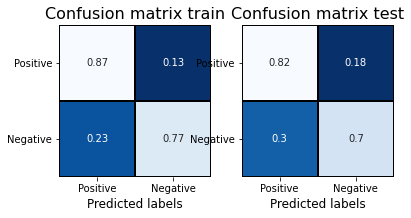

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)       
plot_confusion_matrix(Y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix train',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(Y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix test',
                      class_names=['Positive', 'Negative'])

In [ ]:
confusion_matrix(Y_train,y_train_pred)

array([[30354,  4426],
       [ 8028, 27192]])

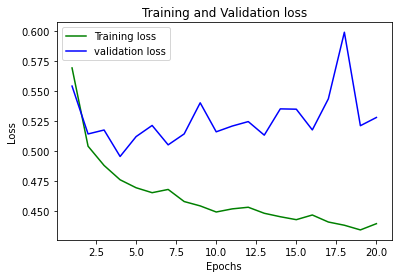

In [ ]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()     

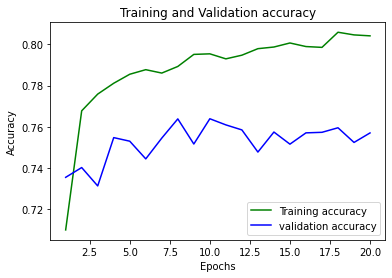

In [ ]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/SDL Lab 1 Twitter/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/SDL Lab 1 Twitter/model.h5")

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/SDL Lab 1 Twitter/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/SDL Lab 1 Twitter/model.h5")

In [ ]:
sent = "It is a sunny morning!!!"
sent = clean_data(sent)
tokens = tokenizer.texts_to_sequences([sent])
tokens = pad_sequences(tokens, maxlen=max_sent_length)
sentiment = loaded_model.predict(np.array(tokens), batch_size=1, verbose = 2)[0][0]
print('Sentiment =', sentiment)
if (round(sentiment) == 0):
    print('Negative')
else:
    print('Positive')

1/1 - 0s
Sentiment = 0.76714724
Positive
